<a href="https://colab.research.google.com/github/JakobRobnik/MicroCanonicalHMC/blob/master/tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MCHMC tutorial - sampling from a Standard Gaussian target distribution**

## Setup

First, let's import the MCHMC code.

In [1]:
!git clone https://github.com/JakobRobnik/MicroCanonicalHMC.git

Cloning into 'MicroCanonicalHMC'...
remote: Enumerating objects: 372, done.
remote: Counting objects: 100% (160/160), done.
remote: Compressing objects: 100% (117/117), done.
remote: Total 372 (delta 94), reused 81 (delta 38), pack-reused 212
Receiving objects: 100% (372/372), 440.60 KiB | 9.18 MiB/s, done.
Resolving deltas: 100% (221/221), done.


We will be using jax, as it can automatically compute gradients.

In [2]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

from MicroCanonicalHMC import ESH

In this example we will sample from a standard Gaussian target. Let's define the negative log density:

In [3]:
nlogp = lambda x: 0.5*jnp.sum(jnp.square(x))

and get the gradient with jax:

In [4]:
grad_nlogp = jax.grad(nlogp)


The target is a class with functions `nlogp`, `grad_nlogp` and `transform`. Some common targets are implemented in `targets.py`.
Let's here define the standard Gaussian target:

In [17]:
class StandardGaussian():
  
  def __init__(self, d):
    self.d = d
  
  def nlogp(self, x):
     return nlogp(x)

  def grad_nlogp(self, x):
     return grad_nlogp(x)

  def transform(self, x):
    return jnp.array([x[0], jnp.sum(jnp.square(x))])

  def prior_draw(self, key):
    """Args: jax random key
       Returns: one random sample from the prior (this is used for initializing the chain)"""

    return jax.random.normal(key, shape = (self.d, ), dtype = 'float64') * 4

`transform` is useful when the dimensionality is high and storing all of the samples becomes memory intesive. We are ususally only iterested in some lower dimensional marginal distribution. `transform` is used in those cases as a map to the lower dimensional space of interest. As an illustration we will here only store $x_1$ and $\sum_{i=1}^d x_i^2$. If not needed it can just be set to the identity.

`prior_draw` must be defined if we want to run parallel chains. It is used to initialize each chain by drawing a random sample from the prior.

##Sampling

Let's sample from a $d = 100$ dimensional target. 
MCHMC has two important tunable parameters, the integration step-size $\epsilon$ and the separation between the momentum resampling $L$. 

For the optimal performance, we want to have $\epsilon$ as large as possible, but not so large that there are significant energy conservation violations. 
For a preconditioned target, $\epsilon \sim 1$ is optimal, so we will start with this value.

For the generalized MCHMC the optimal $L$ is close to $\sqrt{d}$, let's use this value.

In [18]:
d= 100
sampler = ESH.Sampler(StandardGaussian(d), eps = 1.0)
L = jnp.sqrt(d)

We will use gradual momentum decoherence mechanism (`generalized= True`) as this ususally performs slighlty better than the bounce mechanism.

A simple prescription for MCHMC suggests that we should take at least $\frac{n_{\text{eff}} \sqrt{d}}{\epsilon}$ steps, where $n_{\text{eff}}$ is the number of independent effective samples that we want. Let's take 2000 effective samples, so 20000 steps. Of course this will increase for harder targets.

In [19]:
key = jax.random.PRNGKey(0) #random seed
x0 = jnp.ones(d) #initial condition
samples, weights = sampler.sample(x0, 20000, L, key, generalized= True)

The sampler returns the samples and the associated weights.

In [ ]:
print(jnp.shape(samples))
print(jnp.shape(weights))

(20000, 2)
(20000,)


Let's plot the one dimensional marginal distribution along the $x_1$ coordinate.

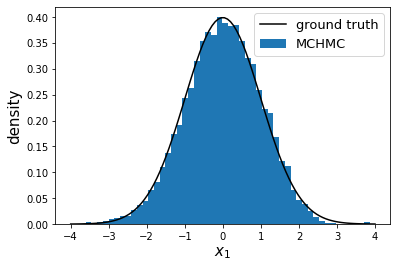

In [8]:
plt.hist(samples[:, 0], bins = 50, weights = weights, density = True, label = 'MCHMC')

from scipy.stats import norm

t = jnp.linspace(-4, 4, 100)
plt.plot(t, norm.pdf(t), color = 'black', label = 'ground truth')

plt.xlabel(r'$x_1$', fontsize = 15)
plt.ylabel('density', fontsize = 15)
plt.legend(fontsize = 13)
plt.show()

Alternatively, we can avoid the weights for ploting purposes and resample according to the weights:

In [9]:
x1 = np.random.choice(samples[:, 0], 10000, p= weights / np.sum(weights))

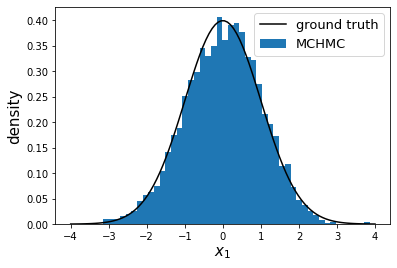

In [10]:
plt.hist(x1, bins = 50, density = True, label = 'MCHMC')

plt.plot(t, norm.pdf(t), color = 'black', label = 'ground truth')

plt.xlabel(r'$x_1$', fontsize = 15)
plt.ylabel('density', fontsize = 15)
plt.legend(fontsize = 13)
plt.show()

##Energy conservation

Posteriors look good. However, a good practice is to check the energy conservation of the sampler and reduce the step size if there are violations. We can do this by setting `monitor_energy = True`.

In [20]:
samples, weights, energy = sampler.sample(x0, 100000, L, key, generalized= True, monitor_energy= True)

Sampler now also ouputs the energy at each step. Let's plot it:

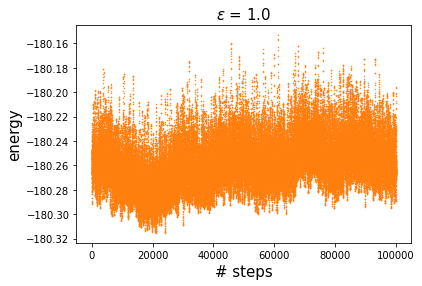

In [21]:
def show_energy():
  plt.plot(energy, '.', markersize= 1, color = 'tab:orange')
  plt.title(r'$\epsilon$ = ' + str(sampler.eps), fontsize = 15)
  plt.xlabel('# steps', fontsize= 15)
  plt.ylabel('energy', fontsize = 15)
  plt.show()

show_energy()

The integration seems stable. If possible, we should try to increase the step size as this will result in a better sampling efficiency. Let's try $\epsilon = 1.5$:

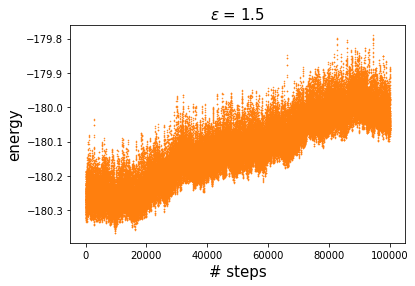

In [22]:
sampler.eps = 1.5
samples, weights, energy = sampler.sample(x0, 100000, L, key, generalized= True, monitor_energy= True)

show_energy()

We see a clear trend, suggesting that $\epsilon = 1$ was a good choice.

##Parallel sampling

Instead of runing one long chain we can run multiple shorter chains. Our target must now have `prior_draw` defined as this is used for initializing the chains. We will run 300 chains for 200 steps:

In [37]:
sampler.eps = 1.0
samples, weights = sampler.sample_multiple_chains(300, 200, L, key, generalized= True)

In [38]:
print(np.shape(samples))
print(np.shape(weights))

(300, 200, 2)
(300, 200)


Let's assign each chain as a whole an equal weight, by normalizing the sum of all weights in each chain:

In [45]:
weights = (weights.T / np.average(weights, axis = 1)).T

The samples from all chains are now combined in a single array with `np.concatenate`. The marginal posterior looks good:

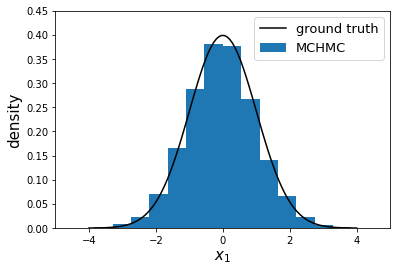

In [49]:
plt.hist(np.concatenate(samples[:, :, 0]), bins = 50, weights = np.concatenate(weights), density = True, label = 'MCHMC')

t = jnp.linspace(-4, 4, 100)
plt.plot(t, norm.pdf(t), color = 'black', label = 'ground truth')

plt.xlabel(r'$x_1$', fontsize = 15)
plt.ylabel('density', fontsize = 15)
plt.legend(fontsize = 13)
plt.xlim(-5, 5)
plt.ylim(0, 0.45)
plt.show()